In [ ]:
import zipfile

# specify the path to the zip file in your Google Drive
zip_path = '/content/drive/MyDrive/dataset.zip'

# specify the path to the folder where you want to unzip the dataset
extract_path = '/content/dataset/'

# extract the contents of the zip file to the extract_path folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [ ]:

# DATA SOURCE -----------------------------------------

batch_size = 25

train_data_dir = r'/content/dataset/dataset/training_set'
validation_data_dir = r'/content/dataset/dataset/test_set'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)



Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:

model.to_json() 

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 150, 150, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 150, 150, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d", "trainable": true, "dtype": "float32", "pool_size": [2, 2], "padding": "valid", "strides": [2, 2]

In [ ]:
#IA GOOGLE

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

model_transfer = VGG16(weights='imagenet', include_top=True)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

model_transfer = VGG16(weights='imagenet', include_top=True)
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)

model_transfer = keras.Model(inputs, outputs)

In [ ]:

model_transfer.compile(loss=tf.keras.losses.categorical_crossentropy,
                      optimizer=tf.keras.optimizers.Adam(1e-3),
                      metrics=['accuracy'])

epochs = 5

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model_transfer.fit(
        train_generator,
        epochs=epochs, 
        validation_data=validation_generator,
        callbacks = [es]
)

Epoch 1/5
320/320 [==============================] - 77s 238ms/step - loss: 0.2152 - accuracy: 0.9103 - val_loss: 0.2538 - val_accuracy: 0.8905
Epoch 2/5
320/320 [==============================] - 75s 233ms/step - loss: 0.2111 - accuracy: 0.9110 - val_loss: 0.2333 - val_accuracy: 0.9005
Epoch 3/5
320/320 [==============================] - 78s 243ms/step - loss: 0.1998 - accuracy: 0.9144 - val_loss: 0.2271 - val_accuracy: 0.9080
Epoch 4/5
320/320 [==============================] - 75s 233ms/step - loss: 0.2021 - accuracy: 0.9136 - val_loss: 0.2353 - val_accuracy: 0.9075
Epoch 5/5
320/320 [==============================] - 84s 261ms/step - loss: 0.1898 - accuracy: 0.9190 - val_loss: 0.2321 - val_accuracy: 0.9005


In [ ]:
img = keras.preprocessing.image.load_img(
    r'/content/dataset/dataset/test_set/cats/cat.4061.jpg', target_size=(250,250)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model_transfer.predict(img_array)
predictions_transfer = model_transfer.predict(img_array)

print(train_generator.class_indices)
print(np.argmax(predictions[0]))
print(np.argmax(predictions_transfer[0]))

1/1 [==============================] - 0s 26ms/step
{'cats': 0, 'dogs': 1}
0
0


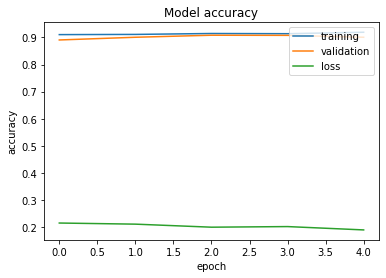

In [ ]:
# EVALUATION ------------------------------------------

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

In [ ]:
# TRANSFER-LEARNING RESULTS ---------------------------

total_val_samples = validation_generator.n
print("El generador de validación tiene", total_val_samples, "imágenes")

steps = total_val_samples // batch_size

results = np.concatenate([(y, model_transfer.predict(x=x)) for x, y in validation_generator], axis=1, steps=steps)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step


KeyboardInterrupt: ignored